# H3 Panel Construction (Crash-Only)

In [1]:
import pandas as pd
import numpy as np
import h3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

sns.set_style('whitegrid')
%matplotlib inline

## 1. Load Cleaned Data

In [2]:
# Load cleaned crashes
df = pd.read_csv('../data/crashes_cleaned.csv', parse_dates=['crash_datetime'])

print(f"Loaded dataset shape: {df.shape}")
print(f"Date range: {df['crash_datetime'].min()} to {df['crash_datetime'].max()}")
print(f"\nFirst 3 rows:")
df.head(3)

Loaded dataset shape: (339749, 16)
Date range: 2022-01-01 00:00:00 to 2025-11-25 23:58:00

First 3 rows:


,collision_id,crash_datetime,latitude,longitude,borough,zip_code,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,vehicle_type_code1
0,4491400,2022-01-01 07:33:00,40.771477,-73.91824,NaN,NaN,0,0,0,0,0,0,0,0,Unspecified,Sedan
1,4491857,2022-01-01 05:17:00,40.746930,-73.84866,NaN,NaN,1,0,0,0,0,0,1,0,Passing or Lane Usage Improper,Sedan
2,4491344,2022-01-01 01:30:00,40.819157,-73.96038,NaN,NaN,0,0,0,0,0,0,0,0,Unspecified,Sedan


## 2. Apply H3 Indexing (Resolution 8)

Resolution 8 ≈ 600m hexagons (neighborhood level)

In [4]:
# Apply H3 indexing
H3_RESOLUTION = 8

def lat_lon_to_h3(lat, lon, res=8):
    """Convert lat/lon to H3 cell ID"""
    return h3.latlng_to_cell(lat, lon, res)

# Apply to all crashes
print(f"Applying H3 indexing at resolution {H3_RESOLUTION}...")
df['h3'] = df.apply(lambda row: lat_lon_to_h3(row['latitude'], row['longitude'], H3_RESOLUTION), axis=1)

# Check results
n_unique_h3 = df['h3'].nunique()
print(f"✓ H3 indexing complete!")
print(f"  Unique H3 cells: {n_unique_h3:,}")
print(f"  Average crashes per cell: {len(df) / n_unique_h3:.1f}")

# Show sample H3 cells
print(f"\nSample H3 cells:")
df[['crash_datetime', 'latitude', 'longitude', 'h3']].head(5)

Applying H3 indexing at resolution 8...
✓ H3 indexing complete!
  Unique H3 cells: 1,135
  Average crashes per cell: 299.3

Sample H3 cells:


,crash_datetime,latitude,longitude,h3
0,2022-01-01 07:33:00,40.771477,-73.91824,882a100f3dfffff
1,2022-01-01 05:17:00,40.746930,-73.84866,882a100e35fffff
2,2022-01-01 01:30:00,40.819157,-73.96038,882a1008c1fffff
3,2022-01-01 16:40:00,40.806107,-73.91799,882a100f6dfffff
4,2022-01-01 13:07:00,40.742737,-73.87643,882a100c47fffff


## 3. Extract Time Features

✓ Time features extracted

Time feature distributions:
  Weekday crashes: 246,163 (72.5%)
  Weekend crashes: 93,586 (27.5%)
  Rush hour crashes: 103,334 (30.4%)


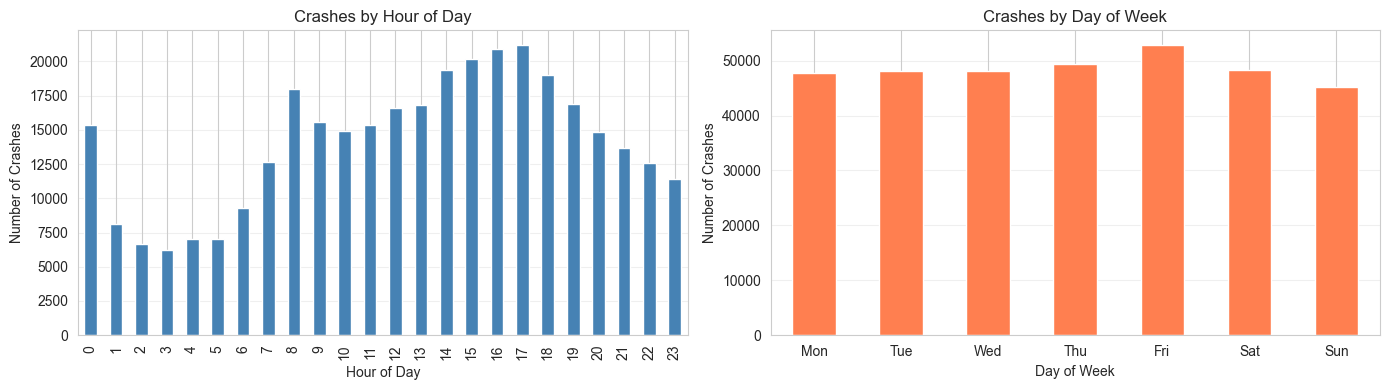

In [6]:
# Extract time features
df['date'] = df['crash_datetime'].dt.date
df['hour'] = df['crash_datetime'].dt.hour
df['day_of_week'] = df['crash_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Saturday, Sunday
df['month'] = df['crash_datetime'].dt.month
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)  # Morning/evening rush

print("✓ Time features extracted")
print(f"\nTime feature distributions:")
print(f"  Weekday crashes: {(df['is_weekend'] == 0).sum():,} ({(df['is_weekend'] == 0).sum()/len(df)*100:.1f}%)")
print(f"  Weekend crashes: {(df['is_weekend'] == 1).sum():,} ({(df['is_weekend'] == 1).sum()/len(df)*100:.1f}%)")
print(f"  Rush hour crashes: {(df['is_rush_hour'] == 1).sum():,} ({(df['is_rush_hour'] == 1).sum()/len(df)*100:.1f}%)")

# Visualize crashes by hour and day of week
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Crashes by hour
crashes_by_hour = df.groupby('hour').size()
crashes_by_hour.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Crashes')
axes[0].set_title('Crashes by Hour of Day')
axes[0].grid(axis='y', alpha=0.3)

# Crashes by day of week
crashes_by_dow = df.groupby('day_of_week').size()
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
crashes_by_dow.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Crashes')
axes[1].set_title('Crashes by Day of Week')
axes[1].set_xticklabels(day_labels, rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Aggregate to (H3, Date, Hour) Panel

**Dense panel:** Only include H3 cells that have had at least 1 crash during the entire period.

In [7]:
# Aggregate crashes by (h3, date, hour)
print("Aggregating to (h3, date, hour) panel...")
panel = df.groupby(['h3', 'date', 'hour']).agg(
    accidents_count=('collision_id', 'count'),
    total_injured=('number_of_persons_injured', 'sum'),
    total_killed=('number_of_persons_killed', 'sum')
).reset_index()

print(f"✓ Aggregated to panel")
print(f"  Panel shape: {panel.shape}")
print(f"  Unique H3 cells: {panel['h3'].nunique():,}")
print(f"  Date range: {panel['date'].min()} to {panel['date'].max()}")
print(f"  Total crashes: {panel['accidents_count'].sum():,}")

# Create binary outcome
panel['accident_indicator'] = (panel['accidents_count'] > 0).astype(int)

print(f"\nPanel statistics:")
print(panel.describe())

Aggregating to (h3, date, hour) panel...
✓ Aggregated to panel
  Panel shape: (334804, 6)
  Unique H3 cells: 1,135
  Date range: 2022-01-01 to 2025-11-25
  Total crashes: 339,749

Panel statistics:
                hour  accidents_count  total_injured   total_killed  \
count  334804.000000    334804.000000  334804.000000  334804.000000   
mean       12.723193         1.014770       0.561953       0.002730   
std         6.299283         0.124193       0.849885       0.054857   
min         0.000000         1.000000       0.000000       0.000000   
25%         8.000000         1.000000       0.000000       0.000000   
50%        14.000000         1.000000       0.000000       0.000000   
75%        18.000000         1.000000       1.000000       0.000000   
max        23.000000         8.000000      34.000000       4.000000   

       accident_indicator  
count            334804.0  
mean                  1.0  
std                   0.0  
min                   1.0  
25%                   

## 5. Add Time Features to Panel

In [11]:
# Convert date to datetime for feature extraction
panel['date_dt'] = pd.to_datetime(panel['date'])

# Extract time features
panel['day_of_week'] = panel['date_dt'].dt.dayofweek
panel['is_weekend'] = panel['day_of_week'].isin([5, 6]).astype(int)
panel['month'] = panel['date_dt'].dt.month
panel['is_rush_hour'] = panel['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

print("✓ Time features added to panel")
print(f"\nSample rows:")
panel.head(10)

✓ Time features added to panel

Sample rows:


,h3,date,hour,accidents_count,total_injured,total_killed,accident_indicator,date_dt,day_of_week,is_weekend,month,is_rush_hour
0,882a100003fffff,2023-11-03,8,1,0,0,1,2023-11-03,4,0,11,1
1,882a100003fffff,2023-12-28,21,1,1,0,1,2023-12-28,3,0,12,0
2,882a100003fffff,2024-01-10,15,1,0,0,1,2024-01-10,2,0,1,0
3,882a100003fffff,2025-02-10,0,1,0,0,1,2025-02-10,0,0,2,0
4,882a100005fffff,2024-03-16,2,1,0,0,1,2024-03-16,5,1,3,0
5,882a100007fffff,2022-01-30,0,1,2,0,1,2022-01-30,6,1,1,0
6,882a100007fffff,2022-01-30,10,1,0,0,1,2022-01-30,6,1,1,0
7,882a100007fffff,2022-03-06,21,1,1,0,1,2022-03-06,6,1,3,0
8,882a100007fffff,2022-03-18,20,1,0,0,1,2022-03-18,4,0,3,0
9,882a100007fffff,2022-04-15,16,1,0,0,1,2022-04-15,4,0,4,0


## 6. Compute Baseline Risk per H3 Cell

Baseline risk = 30-day rolling average of crashes per H3 cell (lagged by 1 day to avoid leakage)

Computing baseline risk (30-day rolling average per H3)...
✓ Baseline risk computed
  Min: 0.000
  Mean: 1.232
  Max: 4.000


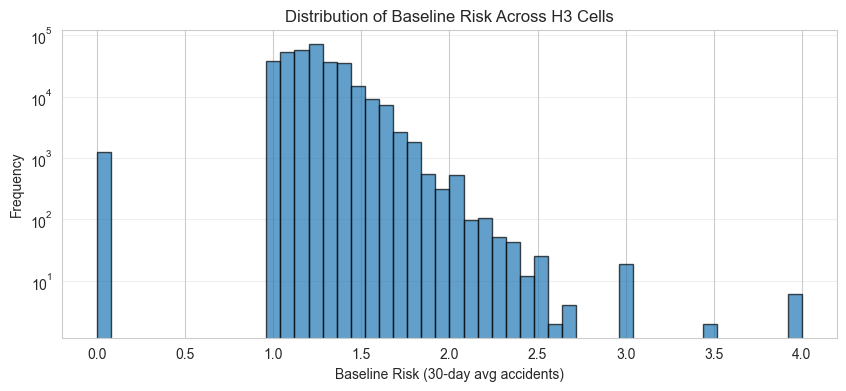

In [12]:
# Sort by h3 and date for rolling calculations
panel = panel.sort_values(['h3', 'date_dt', 'hour']).reset_index(drop=True)

print("Computing baseline risk (30-day rolling average per H3)...")

# Aggregate to daily level first for baseline risk
daily_panel = panel.groupby(['h3', 'date_dt']).agg(
    daily_accidents=('accidents_count', 'sum')
).reset_index()

# Compute 30-day rolling mean (lagged by 1 day)
daily_panel['Baseline_Risk'] = daily_panel.groupby('h3')['daily_accidents'].transform(
    lambda x: x.shift(1).rolling(window=30, min_periods=1).mean()
)

# Merge back to hourly panel
panel = panel.merge(
    daily_panel[['h3', 'date_dt', 'Baseline_Risk']], 
    on=['h3', 'date_dt'], 
    how='left'
)

# Fill first 30 days with forward fill
panel['Baseline_Risk'] = panel.groupby('h3')['Baseline_Risk'].ffill()
panel['Baseline_Risk'] = panel['Baseline_Risk'].fillna(0)  # For any remaining NaNs

print(f"✓ Baseline risk computed")
print(f"  Min: {panel['Baseline_Risk'].min():.3f}")
print(f"  Mean: {panel['Baseline_Risk'].mean():.3f}")
print(f"  Max: {panel['Baseline_Risk'].max():.3f}")

# Visualize baseline risk distribution
plt.figure(figsize=(10, 4))
panel['Baseline_Risk'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Baseline Risk (30-day avg accidents)')
plt.ylabel('Frequency')
plt.title('Distribution of Baseline Risk Across H3 Cells')
plt.yscale('log')
plt.grid(axis='y', alpha=0.3)
plt.show()

## 7. Create Traffic Proxy

Simple MVP proxy: weekday + rush hour (works astoundingly well after validation with real TLC data)

In [13]:
# Traffic proxy: 1 if weekday rush hour, 0 otherwise
panel['Traffic_Proxy'] = (
    (panel['is_weekend'] == 0) & (panel['is_rush_hour'] == 1)
).astype(int)

print("✓ Traffic proxy created")
print(f"  High traffic periods (weekday rush): {panel['Traffic_Proxy'].sum():,} hours ({panel['Traffic_Proxy'].sum()/len(panel)*100:.1f}%)")
print(f"  Low traffic periods: {(panel['Traffic_Proxy'] == 0).sum():,} hours ({(panel['Traffic_Proxy'] == 0).sum()/len(panel)*100:.1f}%)")

✓ Traffic proxy created
  High traffic periods (weekday rush): 79,709 hours (23.8%)
  Low traffic periods: 255,095 hours (76.2%)


## 8. Final Panel Summary & Save

In [14]:
# Select final columns
final_columns = [
    'h3', 'date', 'hour', 
    'accidents_count', 'accident_indicator',
    'total_injured', 'total_killed',
    'day_of_week', 'is_weekend', 'month', 'is_rush_hour',
    'Baseline_Risk', 'Traffic_Proxy'
]

panel_final = panel[final_columns].copy()

# Save to CSV
panel_final.to_csv('../data/h3_panel_res8.csv', index=False)
print(f"✓ Saved H3 panel to ../data/h3_panel_res8.csv")
print(f"  Final shape: {panel_final.shape}")

print(f"\n" + "="*60)
print("H3 PANEL SUMMARY")
print("="*60)
print(f"Panel shape:              {panel_final.shape}")
print(f"Unique H3 cells:          {panel_final['h3'].nunique():,}")
print(f"Date range:               {panel_final['date'].min()} to {panel_final['date'].max()}")
print(f"Total crashes:            {panel_final['accidents_count'].sum():,}")
print(f"Hours with ≥1 crash:      {(panel_final['accident_indicator'] == 1).sum():,} ({(panel_final['accident_indicator'] == 1).sum()/len(panel_final)*100:.1f}%)")
print(f"Total injuries:           {panel_final['total_injured'].sum():,}")
print(f"Total deaths:             {panel_final['total_killed'].sum():,}")
print("="*60)
print("\n✓ H3 panel construction complete!")

✓ Saved H3 panel to ../data/h3_panel_res8.csv
  Final shape: (334804, 13)

H3 PANEL SUMMARY
Panel shape:              (334804, 13)
Unique H3 cells:          1,135
Date range:               2022-01-01 to 2025-11-25
Total crashes:            339,749
Hours with ≥1 crash:      334,804 (100.0%)
Total injuries:           188,144
Total deaths:             914

✓ H3 panel construction complete!
